# Gaussian Process Regression with Elliptical Slice Sampling

[Elliptical slice sampling](https://arxiv.org/abs/1001.0175) is a variant of slice sampling that allows sampling from distributions with multivariate Gaussian prior and arbitrary likelihood. It is generally about as fast as regular slice sampling, mixes well even when the prior covariance might otherwise induce a strong dependence between samples, and does not depend on any tuning parameters. It finds one natural application in working with Gaussian processes, which often use a multivariate Gaussian prior to impose a covariance structure on some latent function.

This notebook provides a simple example of how to use PyMC3's elliptical slice sampler to perform Gaussian process regression. In this example, both the prior and likelihood are Gaussian, so the posterior is also Gaussian and can be derived explicitly. This lets us verify that the sampler produces the correct result.

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
import scipy

sns.set(style='whitegrid', palette='deep', color_codes=True)

%matplotlib inline

### Create some example data

In [2]:
np.random.seed(1)
n = 30
m = 20
noise = 0.005

def f(x):
    """True function."""
    return np.sin(6 * x).flatten()

# Observed data
X0 = np.sort(np.random.rand(n))[:,None]
f_true = f(X0)
f_obs = f_true + np.random.normal(scale=noise**0.5, size=f_true.shape[0])

# We want to make predictions at these points
X = np.linspace(0, 1, m)[:, None]

# Covariance matrices
cov = pm.gp.cov.ExpQuad(1, 1)
K = cov.K(X0).eval()
K_noise = K + noise * np.eye(n)
K_ss = cov.K(X).eval()
K_s = cov.K(X0, X).eval()

The posterior is analytically tractable so we can compute the posterior mean explicitly. We use a numerically stable calculation described Algorithm 2.1 in the book "Gaussian Processes for Machine Learning" (2006) by Rasmussen and Williams, which is [available online for free](http://www.gaussianprocess.org/gpml/).

In [3]:
L = np.linalg.cholesky(K_noise)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, f_obs))
post_mean = np.dot(K_s.T, alpha)

v = np.linalg.solve(L, K_s)
post_cov = K_ss - np.dot(v.T, v)

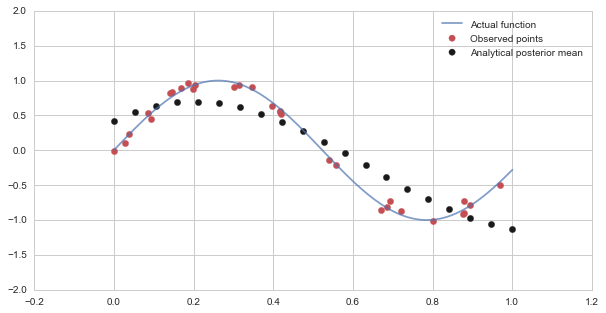

In [4]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.scatter(X0, f_obs,  s=40, color='r', label='Observed points');
ax.scatter(X, post_mean, s=40, color='k', label='Analytical posterior mean');
ax.set_ylim(-2, 2);
ax.plot(np.linspace(0, 1, 100), np.sin(6 * np.linspace(0, 1, 100)), alpha=0.7,
         color='b', label='Actual function');
ax.legend();

### Sample from the model

In [5]:
with pm.Model() as model:
    # Add very small additional noise to covariance to improve numerical stability
    f_sample = pm.MvNormal('f_sample', mu=np.zeros(n), cov=K + 1e-10 * np.eye(n), shape=n)
    y = pm.MvNormal('y', observed=f_obs, mu=f_sample, cov=noise * np.eye(n), shape=n)
    step = pm.EllipticalSlice(prior_cov=K + 1e-10 * np.eye(n))
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_sample))))
    trace = pm.sample(5000, step=step, start=model.test_point, progressbar=False, random_seed=1)

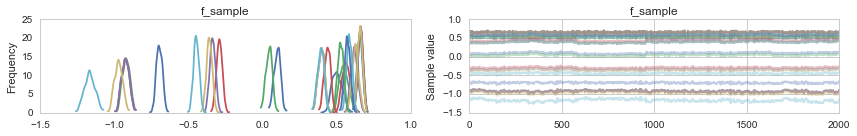

In [6]:
pm.traceplot(trace[3000:], ['f_sample']);

The traceplot shows good mixing and the plot below shows that the posterior mean has been estimated with reasonable accuracy.

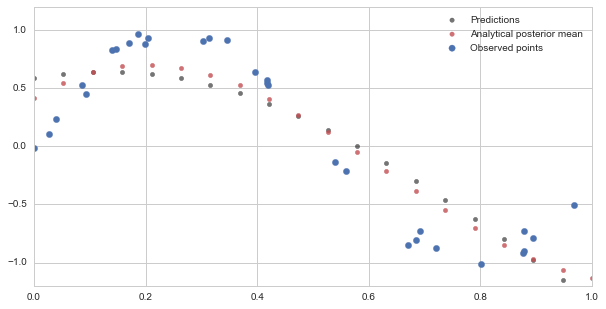

In [7]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.scatter(X, trace[3000:]['f_pred'].mean(axis=0),  alpha=0.6, color='k', label='Predictions')
ax.scatter(X, post_mean, alpha=0.8, color='r', label='Analytical posterior mean')
ax.scatter(X0, f_obs,  s=40, color='b', label='Observed points');
ax.legend();
ax.set_xlim(0, 1);
ax.set_ylim(-1.2, 1.2);